# Libraries used
PV --> Running 3.10.10
Running Kernel3.9.13 base anaconda

#perform al pip installs in one go comment out if already installed
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install scipy
!pip install statsmodels
!pip install plotly
!pip install cufflinks
!pip install squarify
!pip install yellowbrick
!pip install lazypredict
!pip install pandas_profiling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
import plotly.io as pio
#import squarify #treemap
import os
import matplotlib
import warnings



#to enable the inline plotting
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

In [2]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from scipy.stats import normaltest

from pandas_profiling import ProfileReport

from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette

import lazypredict
from lazypredict.Supervised import LazyClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)

# Functions


In [3]:
# Function for EDA. Using the display() function to have  well-formatted tables. We are mainly using pandas to explore the datasets

def dataset_description(df_target):

    print('This is the Dataset shape: %s\n' % (df_target.shape, ))
    print('Dataset columns: %s\n' % df_target.columns)

    print('\nColumns description:\n')
    display(df_target.info())
    display(df_target.describe())  # describe the dataset

    print('\nNull values:\n')
    display(df_target.isnull().sum())  # Identify null values

#function performing a quick check on df_inspection to have best of pandas functions separated by a line
def quick_check(dataframe):
    print('First 5 rows %s\n')
    print(dataframe.head(2))
    print("=====================================")
    print('Dataframe shape %s\n')
    print(dataframe.shape)
    print("=====================================")
    print('Dataframe describe categorical %s\n')
    print(dataframe.describe(include=['O']))
    print("=====================================")
    print('Dataframe null values %s\n')
    print(dataframe.isnull().sum())
    print("=====================================")
    print('Dataframe value counts %s\n')
    print(dataframe.value_counts())
    print("=====================================")

#stats function
def stats(dataframe):
    print('Dataframe correlation %s\n')
    print(dataframe.corr())
    print("=====================================")
    print('Dataframe covariance %s\n')
    print(dataframe.cov())
    print("=====================================")
    print('Dataframe skew %s\n')
    print(dataframe.skew())
    print("=====================================")
    print('Dataframe kurtosis %s\n')
    print(dataframe.kurt())
    print("=====================================")

#create a function to normalize characters from a dataset's column in Spanish
def normalize_characters(df, column):
    df[column] = df[column].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace('á', 'a')
    df[column] = df[column].str.replace('é', 'e')
    df[column] = df[column].str.replace('í', 'i')
    df[column] = df[column].str.replace('ó', 'o')
    df[column] = df[column].str.replace('ú', 'u')
    df[column] = df[column].str.replace('ñ', 'n')
    df[column] = df[column].str.replace('ü', 'u')
    df[column] = df[column].str.replace('ç', 'c')
    df[column] = df[column].str.replace('(', '')
    df[column] = df[column].str.replace(')', '')
    df[column] = df[column].str.replace('\'', '')
    df[column] = df[column].str.replace('´', '')
    df[column] = df[column].str.replace('`', '')
    df[column] = df[column].str.replace('’', '')
    return df.head(2)

#create function to change detypes in64 to int32 in a df
def change_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
        elif df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
    return df

def outlier_function(df, col_name):
    """ this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively"""
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                        
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                    
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
        else:
            pass
    return lower_limit, upper_limit, outlier_count

In [4]:
#show all print outputs when using a function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#display all columns
pd.set_option('display.max_columns', None)


# 2. Data Collection and Understanding 

## Network file

The network.csv file contains a static picture of the gas pipeline network. Every row corresponds to a pipe and has a unique PipeId identifier. The table has 1.446.529 pipes. 

The columns describe relevant features of each pipe. The complete list is: 

PipeId - unique identifier for the pipe 

Province - Spanish province where the pipe is located 

Town - Town or city where the pipe is located 

YearBuilt - Year in which the pipe was built and installed 

Material - Material in which the pipe is built 

GasType - Type of gas that runs through the pipe 

Diameter - diameter of the pipe 

Length - Length of the pipe 

Pressure - Pressure of the gas that runs through the pipe (bar) 

NumConnections - Number of connections (external). 

NumConnectionsUnder - Number of connections (internal and buried) 

BoolBridle  - Whether the pipe is bridled (True) or welded (False) 

## Inspection file

MaintenanceId - unique identifier for the inspection operation 

InspectionYear - year in which the inspection took place 

InspectionDate - date in which the inspection took place 

MonthsLastRev - number of months elapsed since the last previous inspection. 

Severity - Severity of the damage found (1: most severe, 3: least severe) 

Incidence - Boolean whether an incident was found on the revision (1) or not (0). 

# Merging datasets

In [5]:
#point to the folder where the data is stored for Pedro
os.chdir(r"C:\Users\pedro\datathon")

# Loading inspection data
df_inspection = pd.read_csv('inspections.csv')

# Loading network data
df_network = pd.read_csv('network.csv')


In [6]:
#point to the folder where the data is stored for Pedro
os.chdir(r"C:\Users\pedro\datathon\Datathon-Rules-and-Documentation") 

#Loading sample_submission
df_sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
#point to the folder where the data is stored For Juan
os.chdir(r"C:\Users\JuanHorrillo\OneDrive - IE Students\Documents\Masters\Sustainability\Notebook")

# Loading inspection data
df_inspection = pd.read_csv('inspections.csv')

# Loading network data
df_network = pd.read_csv('network.csv')

In [6]:
quick_check(df_inspection)


First 5 rows %s

      PipeId MaintenanceId  InspectionYear InspectionDate  MonthsLastRev  \
0  189311802  ZRV-00001972            2010     2010-10-01             24   
1  188889914  ZRV-00001406            2010     2010-10-01             22   

   Severity  Incidence  
0         4          0  
1         4          0  
Dataframe shape %s

(6345344, 7)
Dataframe describe categorical %s

       MaintenanceId InspectionDate
count        6345344        6345344
unique          4179           3565
top     ZRV-00002121     2014-05-05
freq           21773           5832
Dataframe null values %s

PipeId            0
MaintenanceId     0
InspectionYear    0
InspectionDate    0
MonthsLastRev     0
Severity          0
Incidence         0
dtype: int64
Dataframe value counts %s

PipeId     MaintenanceId  InspectionYear  InspectionDate  MonthsLastRev  Severity  Incidence
489616     ZRV-00003385   2013            2013-05-08      16             4         0            1
256852211  ZRV-00002129   2016    

The function shows we have 6345344 rows for the inspections, among each 4179 appear to be unique and the most repeated one is ZRV-00002121 on 2014-05-05


In [7]:
#searching for MaintenanceId ZRV-00002121 in df_inspection
df_inspection[df_inspection['MaintenanceId'] == 'ZRV-00002121']

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence
622563,188821075,ZRV-00002121,2012,2011-12-28,24,4,0
622571,191340447,ZRV-00002121,2012,2011-12-28,24,4,0
622572,191340427,ZRV-00002121,2012,2011-12-28,24,4,0
622574,191340421,ZRV-00002121,2012,2011-12-28,24,4,0
622575,188802580,ZRV-00002121,2012,2011-12-28,24,4,0
...,...,...,...,...,...,...,...
5737006,450197378,ZRV-00002121,2020,2020-01-29,24,4,0
5737013,358229516,ZRV-00002121,2020,2020-01-29,24,4,0
5737179,351671916,ZRV-00002121,2020,2020-01-29,24,4,0
5737289,351671518,ZRV-00002121,2020,2020-01-29,24,4,0


In [8]:
df_inspection[df_inspection['MaintenanceId'] == 'ZRV-00002121'].shape

(21773, 7)

<AxesSubplot:xlabel='InspectionYear'>

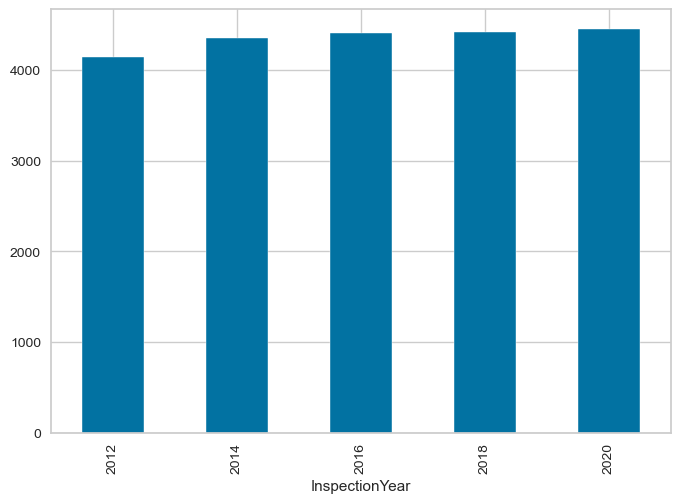

In [9]:
#plotting the distribution of MaintenanceId accross the years for ZRV-00002121 in df_inspection
df_inspection[df_inspection['MaintenanceId'] == 'ZRV-00002121'].groupby('InspectionYear')['MaintenanceId'].count().plot(kind='bar')

<AxesSubplot:xlabel='InspectionYear'>

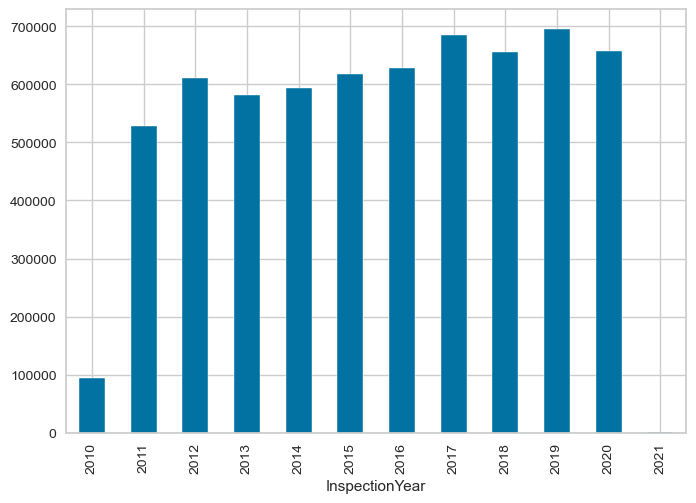

In [10]:
#plotting the distribution of MaintenanceId accross the years
df_inspection.groupby('InspectionYear')['MaintenanceId'].count().plot(kind='bar')

Seems like not so many inspections were carried in 2010, we shall decide on whether to keep this dimension or not

In [11]:
stats(df_inspection)

Dataframe correlation %s

                PipeId  InspectionYear  MonthsLastRev  Severity  Incidence
PipeId            1.00           -0.12           0.05      0.02      -0.02
InspectionYear   -0.12            1.00           0.12      0.00      -0.00
MonthsLastRev     0.05            0.12           1.00      0.01      -0.01
Severity          0.02            0.00           0.01      1.00      -0.90
Incidence        -0.02           -0.00          -0.01     -0.90       1.00
Dataframe covariance %s

                             PipeId  InspectionYear  MonthsLastRev  Severity  \
PipeId         12943583115885750.00    -40999914.58    27545538.86 129283.54   
InspectionYear         -40999914.58            8.46           1.70      0.00   
MonthsLastRev           27545538.86            1.70          24.62      0.00   
Severity                  129283.54            0.00           0.00      0.00   
Incidence                -107454.24           -0.00          -0.00     -0.00   

                In

 A positive kurtosis in a dataset implies that the data is more heavily concentrated around the mean than a normal distribution. This means that there are more outliers in the dataset and that the tails of the distribution are longer and fatter than a normal distribution. Months last revision is to be examined on this basis

<AxesSubplot:>

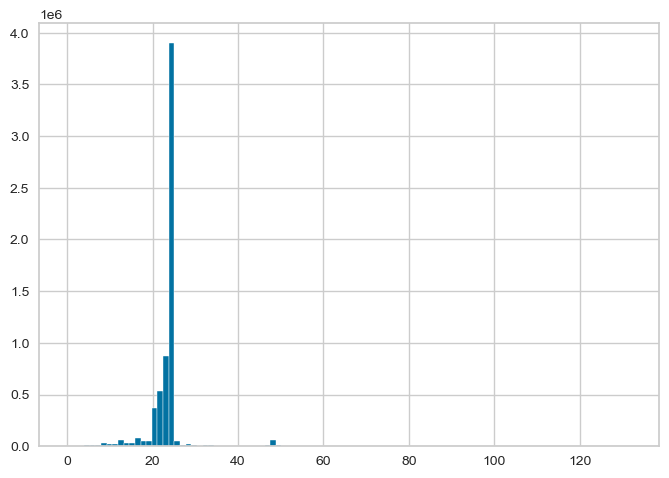

In [12]:
#plot histogram with many bins of MonthsLastRev in  df_inspection
df_inspection['MonthsLastRev'].hist(bins=100)

The shape of the histogram reveals the most frequent inspections take place every 2 years or 24 months with some outliers hence affecting the normal distribution

<AxesSubplot:xlabel='PipeId', ylabel='MonthsLastRev'>

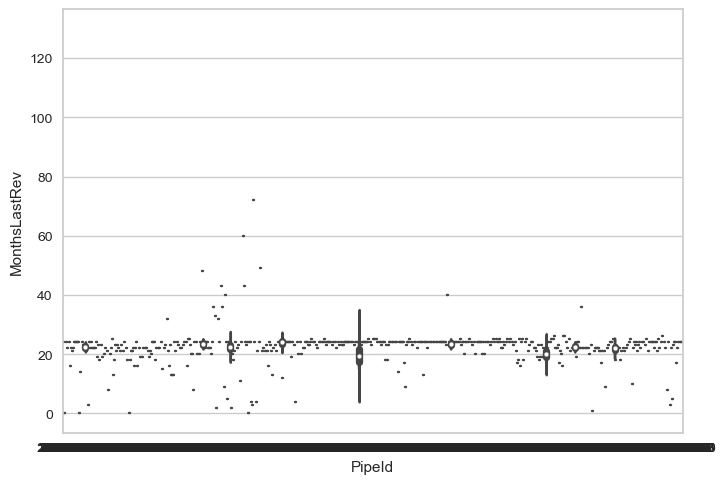

In [13]:
#plot violin plot of PipeId with Severity=1 in df_inspection
sns.violinplot(x='PipeId', y='MonthsLastRev', data=df_inspection[df_inspection['Severity'] == 1])

#to work out better in final EDA

In [14]:
quick_check(df_network)

First 5 rows %s

   PipeId     Province                   Town  YearBuilt Material  \
0  489616  Ciudad Real  Torralba de Calatrava       2012       PE   
1  489645  Ciudad Real  Torralba de Calatrava       2012       PE   

       GasType  Diameter  Length  Pressure  NumConnections  \
0  Gas natural     63.00    7.79      0.40               0   
1  Gas natural     90.00    2.08      0.40               0   

   NumConnectionsUnder  BoolBridle  
0                    0       False  
1                    0       False  
Dataframe shape %s

(1446539, 12)
Dataframe describe categorical %s

         Province     Town Material      GasType
count     1446539  1446539  1446539      1446539
unique         38     1972       11            2
top     Barcelona   Madrid       PE  Gas natural
freq       389307    76666  1242845      1388397
Dataframe null values %s

PipeId                 0
Province               0
Town                   0
YearBuilt              0
Material               0
GasType     

In the network file we find 1446539 rows corresponding to all pipes, this is the master file for pipes.
We find the most frequent Town is Madrid but the most frequent province is Barcelona. 
There are a total of 1972 Spanish towns in this dataset and 38 provinces
We are missing the Basque Country, Ceuta, Melilla, the Canary Islands and Balearic Islands.



<AxesSubplot:xlabel='Town'>

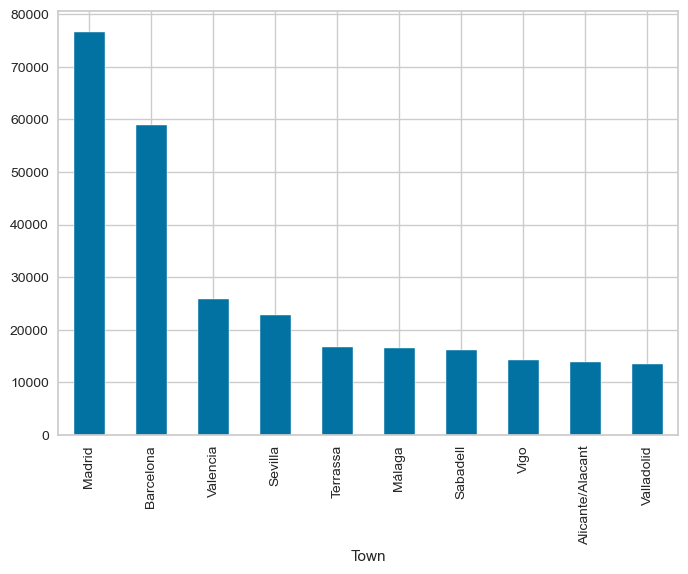

In [15]:
#plot a bar plot with the number of pipes per Town focusing in Madrid and Barcelona  in df_network
df_network.groupby('Town')['PipeId'].count().sort_values(ascending=False).head(10).plot(kind='bar')

<AxesSubplot:ylabel='PipeId'>

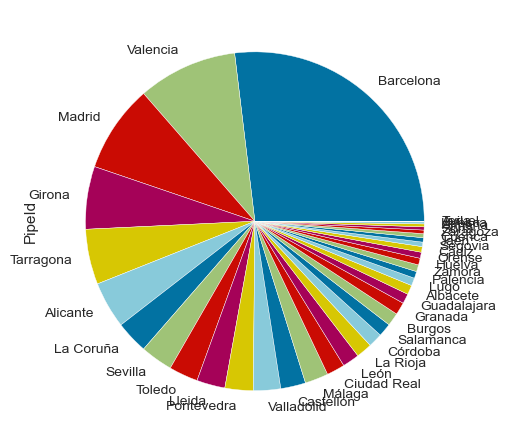

In [16]:
#plot a pie chart with the number of pipes per Province in df_network 
df_network.groupby('Province')['PipeId'].count().sort_values(ascending=False).plot(kind='pie')


In [17]:
stats(df_network)

Dataframe correlation %s

                     PipeId  YearBuilt  Diameter  Length  Pressure  \
PipeId                 1.00      -0.05      0.13   -0.01      0.04   
YearBuilt             -0.05       1.00     -0.16    0.03      0.05   
Diameter               0.13      -0.16      1.00    0.07      0.19   
Length                -0.01       0.03      0.07    1.00      0.11   
Pressure               0.04       0.05      0.19    0.11      1.00   
NumConnections        -0.05      -0.03     -0.11    0.31     -0.10   
NumConnectionsUnder   -0.01       0.01     -0.01    0.02     -0.00   
BoolBridle            -0.09      -0.18      0.09   -0.02     -0.07   

                     NumConnections  NumConnectionsUnder  BoolBridle  
PipeId                        -0.05                -0.01       -0.09  
YearBuilt                     -0.03                 0.01       -0.18  
Diameter                      -0.11                -0.01        0.09  
Length                         0.31                 0.02   

In [18]:
#join Inspection and network datasets on PipeId to create our TRAIN dataset
train = pd.merge(df_inspection, df_network, on='PipeId', how='right')

In [19]:
train.shape

(6364029, 18)

In [20]:
df_inspection.shape

(6345344, 7)

JF: There are 18K null values that do not have information in the df_network so our TRAIN data set is now bigger and we will need to deal with the nulls further down.

In [21]:
#count null values in train dataset
train.isnull().sum()


PipeId                     0
MaintenanceId          18685
InspectionYear         18685
InspectionDate         18685
MonthsLastRev          18685
Severity               18685
Incidence              18685
Province                   0
Town                       0
YearBuilt                  0
Material                   0
GasType                    0
Diameter                   0
Length                     0
Pressure                   0
NumConnections             0
NumConnectionsUnder        0
BoolBridle                 0
dtype: int64

In [23]:
#point to the folder where the data is stored for Pedro
os.chdir(r"C:\Users\pedro\datathon\Datathon-Rules-and-Documentation")

# Loading inspection data
df_sample = pd.read_csv('sample_submission.csv')

In [22]:
#point to the folder where the data is stored for Juan
os.chdir(r"C:\Users\JuanHorrillo\OneDrive - IE Students\Documents\Masters\Sustainability\Notebook")

# Loading inspection data
df_sample = pd.read_csv('sample_submission.csv')

In [23]:
df_sample.shape

(909733, 2)

In [24]:
df_sample.head()

,PipeId,Incidence
0,446859944,0
1,428124500,0
2,438428871,0
3,429034569,0
4,411184477,0


In [25]:
#count the Incidence values in test dataset
df_sample['Incidence'].value_counts()



0    907964
1      1769
Name: Incidence, dtype: int64

Test data set is also unbalanced 

Creating the TEST df which will be used to test our model.  Thisis made of the sample submission with the columns from the network

In [26]:
#create a dataframe with the unique PipeId from df_sample and a dataframe with the PipeId from df_network 
sample_unique = df_sample['PipeId'].unique()
network_unique = df_network['PipeId'].unique()
#check if all the values in sample_unique are in network_unique
np.all(np.isin(sample_unique, network_unique))

True

JF: All the PipeId on the df_sample have a PipeId on the network

In [27]:
#join both datasets on PipeId
test = pd.merge(df_network , df_sample, on='PipeId', how='right')

In [28]:
test.shape

(909733, 13)

In [29]:
test.head(2)

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,Incidence
0,446859944,Valencia,Alginet,2012,PE,Gas natural,110.00,44.29,0.15,0,0,False,0
1,428124500,Valencia,Alginet,2012,PE,Gas natural,160.00,110.72,0.15,2,0,False,0


In [30]:
df_sample.head(3)

,PipeId,Incidence
0,446859944,0
1,428124500,0
2,438428871,0


In [31]:
#Check for null values in test dataset
test_null = test.isnull().sum()    
test_null.head()

PipeId       0
Province     0
Town         0
YearBuilt    0
Material     0
dtype: int64

JF: No null Values in TEST data set

In [32]:
#creating a subset for altering the dataset after initial EDA
train_copy = train.copy()

In [33]:
#find the columns with null values in train_copy
train_copy.isnull().sum()

PipeId                     0
MaintenanceId          18685
InspectionYear         18685
InspectionDate         18685
MonthsLastRev          18685
Severity               18685
Incidence              18685
Province                   0
Town                       0
YearBuilt                  0
Material                   0
GasType                    0
Diameter                   0
Length                     0
Pressure                   0
NumConnections             0
NumConnectionsUnder        0
BoolBridle                 0
dtype: int64

In [34]:
#show me a head of train_copy with YearBuilt == 2020
train_copy[train_copy['YearBuilt'] > 2020].head(2)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
64887,185802404,NaN,NaN,NaN,NaN,NaN,NaN,Girona,Puigcerda,2021,PN,Gas natural,110.00,12.01,0.15,1,0,True
64889,188243116,NaN,NaN,NaN,NaN,NaN,NaN,Girona,Puigcerda,2021,PN,Gas natural,90.00,11.82,0.15,1,0,True


In [35]:
#count the PipeID that have YearBuilt equal to 2021 and InspectionYear equal to NaN
train_copy[(train_copy['YearBuilt'] > 2020) & (train_copy['InspectionYear'].isnull())].shape


(2026, 18)

JF: There are 2026 pipes that were built after 2020 in the train data set, these came from the network data set and will be considered new pipes that do not have inspection data yet. We will assume that the inspection year for those was the year of installation (you inspect them when you install them)

In [36]:
#show me nulls for InspectionYear for every year in train_copy
train_copy.groupby('InspectionYear')['InspectionYear'].count()

InspectionYear
2010.00     93518
2011.00    528113
2012.00    611594
2013.00    581559
2014.00    593223
2015.00    617187
2016.00    627667
2017.00    684715
2018.00    654861
2019.00    694584
2020.00    656878
2021.00      1445
Name: InspectionYear, dtype: int64

In [37]:
#do a range in the train_copy for the YearBuilt column if the value is greater than 2020 and the InspectionYear is equal to Nan, change the value of InspectionYear to YearBuilt

#for i in train_copy['YearBuilt']:
#    if i > 2020:
#        train_copy.loc[(train_copy['YearBuilt'] > 2020) & (train_copy['InspectionYear'].isnull()), 'InspectionYear'] = i

In [38]:
#show me the YearBuilt values for the null vales in InspectionYear
train_copy[train_copy['InspectionYear'].isnull()]['YearBuilt'].value_counts()


2020    3290
2019    2654
2021    1960
2016    1144
2015     873
        ... 
1971       7
1969       2
1965       2
1966       1
1967       1
Name: YearBuilt, Length: 61, dtype: int64

In [39]:
#remove from train_copy the rows where InspectionYear is equal to NaN and yearBuilt is not null
train_copy = train_copy[~((train_copy['InspectionYear'].isnull()) & (train_copy['YearBuilt'].notnull()))]

We do not have info for these pipes so I will remove them all as it is impossible to find out the year built

In [40]:
train_copy.isnull().sum()

PipeId                 0
MaintenanceId          0
InspectionYear         0
InspectionDate         0
MonthsLastRev          0
Severity               0
Incidence              0
Province               0
Town                   0
YearBuilt              0
Material               0
GasType                0
Diameter               0
Length                 0
Pressure               0
NumConnections         0
NumConnectionsUnder    0
BoolBridle             0
dtype: int64

In [41]:
#count the PipeId in inspection dataset that YearBuilt is equal to 2020 and inspection year is equal to 2021
train_copy[(train_copy['YearBuilt'] > 2020) & (train_copy['InspectionYear'] == 2021)].shape



(0, 18)

# 2. Data Collection and Understanding 

The network.csv file contains a static picture of the gas pipeline network. Every row corresponds to a pipe and has a unique PipeId identifier. The table has 1.446.529 pipes. 

The columns describe relevant features of each pipe. The complete list is: 



## Inspection file

# Merging datasets

# Juan: All this is duplicated, we need to check and drop one of them, it is making the notebook heavy

In [46]:
#point to the folder where the data is stored for Pedro
os.chdir(r"C:\Users\pedro\datathon\Datathon-Rules-and-Documentation") 

#Loading sample_submission
df_sample_submission = pd.read_csv('sample_submission.csv')

<AxesSubplot:>

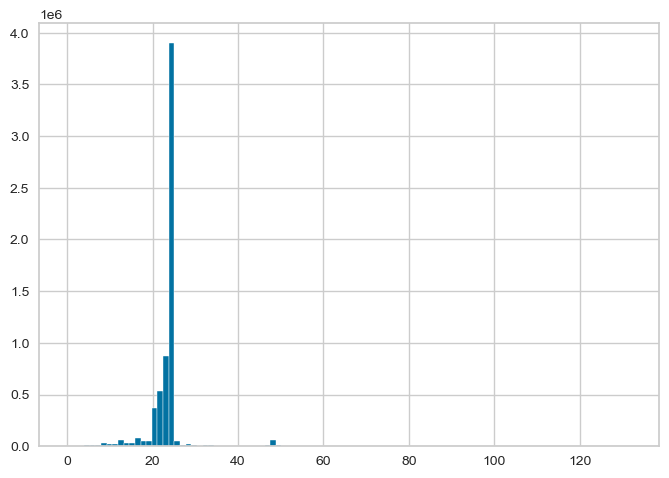

In [42]:
#plot histogram with many bins of MonthsLastRev in  df_inspection
df_inspection['MonthsLastRev'].hist(bins=100)

In [52]:
#JUAN we kill more than 40 months revision

#to work out better in final EDA

In the network file we find 1446539 rows corresponding to all pipes, this is the master file for pipes.
We find the most frequent Town is Madrid but the most frequent province is Barcelona. 
There are a total of 1972 Spanish towns in this dataset and 38 provinces
We are missing the Basque Country, Ceuta, Melilla, the Canary Islands and Balearic Islands.



In [43]:
train.shape 

(6364029, 18)

JF: There are 18K null values that do not have information in the df_network so our TRAIN data set is now bigger and we will need to deal with the nulls further down.

In [56]:
#point to the folder where the data is stored for Pedro
os.chdir(r"C:\Users\pedro\datathon\Datathon-Rules-and-Documentation")

# Loading inspection data
df_sample = pd.read_csv('sample_submission.csv')

In [44]:
df_sample.shape

(909733, 2)

In [45]:
#count the Incidence values in test dataset
df_sample['Incidence'].value_counts()



0    907964
1      1769
Name: Incidence, dtype: int64

Creating the TEST df which will be used to test our model.  Thisis made of the sample submission with the columns from the network

JF: All the PipeId on the df_sample have a PipeId on the network

In [46]:
#join both datasets on PipeId
test = pd.merge(df_network , df_sample, on='PipeId', how='right')

In [47]:
test.head()

,PipeId,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,Incidence
0,446859944,Valencia,Alginet,2012,PE,Gas natural,110.00,44.29,0.15,0,0,False,0
1,428124500,Valencia,Alginet,2012,PE,Gas natural,160.00,110.72,0.15,2,0,False,0
2,438428871,Valencia,Alginet,2012,PE,Gas natural,110.00,13.57,0.15,0,0,False,0
3,429034569,Valencia,Alginet,2012,PE,Gas natural,110.00,327.69,0.15,3,0,False,0
4,411184477,Valencia,Alginet,2007,PE,Gas natural,200.00,932.76,0.15,0,0,False,0


In [48]:
#Check for null values in test dataset
test_null = test.isnull().sum()    
test_null.head()

PipeId       0
Province     0
Town         0
YearBuilt    0
Material     0
dtype: int64

In [49]:
#creating a subset for altering the dataset after initial EDA
train_copy = train.copy()

In [50]:
#show me a head of train_copy with YearBuilt == 2020
train_copy[train_copy['YearBuilt'] > 2020].head()

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
64887,185802404,NaN,NaN,NaN,NaN,NaN,NaN,Girona,Puigcerda,2021,PN,Gas natural,110.00,12.01,0.15,1,0,True
64889,188243116,NaN,NaN,NaN,NaN,NaN,NaN,Girona,Puigcerda,2021,PN,Gas natural,90.00,11.82,0.15,1,0,True
70787,185839446,NaN,NaN,NaN,NaN,NaN,NaN,Girona,Girona,2021,PN,Gas natural,110.00,5.10,0.03,1,0,True
70788,186392655,NaN,NaN,NaN,NaN,NaN,NaN,Girona,Girona,2021,PN,Gas natural,63.00,4.51,0.03,1,0,True
70790,186441076,NaN,NaN,NaN,NaN,NaN,NaN,Girona,Girona,2021,PN,Gas natural,63.00,0.29,0.03,0,0,True


JF: There are 2026 pipes that were built after 2020 in the train data set, these came from the network data set and will be considered new pipes that do not have inspection data yet. We will assume that the inspection year for those was the year of installation (you inspect them when you install them)

In [51]:
#show me nulls for InspectionYear for every year in train_copy
train_copy.groupby('InspectionYear')['InspectionYear'].count()

InspectionYear
2010.00     93518
2011.00    528113
2012.00    611594
2013.00    581559
2014.00    593223
2015.00    617187
2016.00    627667
2017.00    684715
2018.00    654861
2019.00    694584
2020.00    656878
2021.00      1445
Name: InspectionYear, dtype: int64

In [52]:
train_copy.isnull().sum()

PipeId                     0
MaintenanceId          18685
InspectionYear         18685
InspectionDate         18685
MonthsLastRev          18685
Severity               18685
Incidence              18685
Province                   0
Town                       0
YearBuilt                  0
Material                   0
GasType                    0
Diameter                   0
Length                     0
Pressure                   0
NumConnections             0
NumConnectionsUnder        0
BoolBridle                 0
dtype: int64

In [53]:
#show me a head of train_copy with YearBuilt higher than InspectionYear and count them
train_copy[(train_copy['YearBuilt'] > train_copy['InspectionYear'])].shape

(7672, 18)

# Feature Engineering on combined dataset

As a result of merging both datasets we now have pipeline duplicates per each maintenace_id operation. Before getting rid of the duplicates, we want to engineer some metrics interesting to the model such as number of operations, number of incidents and average risk based on severity*incidence

In [55]:
train_copy.head(3)

,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,ZRV-00003385,2013.00,2013-05-08,16.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False
1,489616,ZRV-00003385,2015.00,2015-03-04,22.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False
2,489616,ZRV-00003385,2016.00,2017-01-12,22.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False


In [66]:
#show the type of all the columns in train_copy
train_copy.dtypes

PipeId                   int64
MaintenanceId           object
InspectionYear         float64
InspectionDate          object
MonthsLastRev          float64
Severity               float64
Incidence              float64
Province                object
Town                    object
YearBuilt                int64
Material                object
GasType                 object
Diameter               float64
Length                 float64
Pressure               float64
NumConnections           int64
NumConnectionsUnder      int64
BoolBridle                bool
dtype: object

In [68]:
#show nulls in InspectionYear
train_copy[train_copy['InspectionYear'].isnull()].shape

(18685, 18)

## This formula is still wrong and I could not fix it

In [78]:
#create a new column called 'No_Inspections' that is a sum that the number of inspections per PipeId that is less than InspectionYear that are not null in that row
train_copy['No_Inspections'] = train_copy.groupby('PipeId')['InspectionYear'].transform(lambda x: x[x.notnull()].count())



In [77]:
#drop the column No_Inspections
train_copy.drop('No_Inspections', axis=1, inplace=True)

In [79]:
#show in train_copy all the rows with PipeId 489616
train_copy[train_copy['PipeId'] == 489616]


,PipeId,MaintenanceId,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,No_Inspections
0,489616,ZRV-00003385,2013.00,2013-05-08,16.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False,5
1,489616,ZRV-00003385,2015.00,2015-03-04,22.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False,5
2,489616,ZRV-00003385,2016.00,2017-01-12,22.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False,5
3,489616,ZRV-00003385,2018.00,2018-12-19,23.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False,5
4,489616,ZRV-00003385,2020.00,2020-12-05,24.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False,5


In [80]:
#create a new column counting the number of inspections (MaintenanceId) per PipeId
train_copy['No_Inspections'] = train_copy.groupby('PipeId')['MaintenanceId'].transform('count')
#aggregate the number of Incidents per pipe in a new column and place it in the fourth position
train_copy['No_Incidents'] = train_copy.groupby('PipeId')['Incidence'].transform('sum')
#place the new columns in the third position
cols = list(train_copy.columns.values)
cols.pop(cols.index('No_Incidents'))
train_copy = train_copy[['PipeId', 'MaintenanceId', 'No_Inspections', 'No_Incidents', 'InspectionYear', 'InspectionDate',
       'MonthsLastRev', 'Severity', 'Incidence', 'Province', 'Town',
       'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle']]
#show head of rows only where No_Incidents is greater than 0
train_copy[train_copy['No_Incidents'] > 2].head(2)


'No_Incidents'

,PipeId,MaintenanceId,No_Inspections,No_Incidents,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
637351,2157313,ZRV-00003476,5,3.00,2012.00,2012-11-28,10.00,4.00,0.00,Sevilla,Mairena del Aljarafe,2012,CU,Gas natural,15.00,25.58,4.00,2,0,True
637352,2157313,ZRV-00003476,5,3.00,2014.00,2014-12-10,35.00,3.00,1.00,Sevilla,Mairena del Aljarafe,2012,CU,Gas natural,15.00,25.58,4.00,2,0,True


In [81]:
train_copy.columns

Index(['PipeId', 'MaintenanceId', 'No_Inspections', 'No_Incidents',
       'InspectionYear', 'InspectionDate', 'MonthsLastRev', 'Severity',
       'Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
       'Diameter', 'Length', 'Pressure', 'NumConnections',
       'NumConnectionsUnder', 'BoolBridle'],
      dtype='object')

In [82]:
#create a column named average_severity_pipe that calculates the average severity per pipe aggregating all severities
train_copy['average_severity_pipe'] = train_copy.groupby('PipeId')['Severity'].transform('mean')
#show head of rows only where mean has a decimal value
train_copy[train_copy['average_severity_pipe'] % 1 != 0].head(10)
#place the new column in 7th position
cols = list(train_copy.columns.values)
cols.pop(cols.index('average_severity_pipe'))
train_copy = train_copy[['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'InspectionDate', 'MonthsLastRev', 'average_severity_pipe','Severity', 'Incidence', 'Province',
       'Town', 'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length',
       'Pressure', 'NumConnections', 'NumConnectionsUnder', 'BoolBridle']]


,PipeId,MaintenanceId,No_Inspections,No_Incidents,InspectionYear,InspectionDate,MonthsLastRev,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,average_severity_pipe
12371,35790261,ZRV-00007259,2,1.00,2018.00,2018-02-23,9.00,3.00,1.00,Córdoba,Lucena,2016,PE,Gas natural,32.00,87.83,0.15,12,0,False,3.50
12372,35790261,ZRV-00003409,2,1.00,2020.00,2020-05-20,27.00,4.00,0.00,Córdoba,Lucena,2016,PE,Gas natural,32.00,87.83,0.15,12,0,False,3.50
12725,3663205,ZRV-00003435,4,1.00,2013.00,2013-05-15,16.00,3.00,1.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False,3.75
12726,3663205,ZRV-00003435,4,1.00,2015.00,2015-05-26,24.00,4.00,0.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False,3.75
12727,3663205,ZRV-00003435,4,1.00,2017.00,2017-05-10,24.00,4.00,0.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False,3.75
12728,3663205,ZRV-00003435,4,1.00,2019.00,2019-05-10,24.00,4.00,0.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False,3.75
15120,228066029,ZRV-00003435,5,1.00,2012.00,2012-03-22,22.00,4.00,0.00,Granada,Granada,1998,PE,Gas natural,200.00,171.11,0.15,5,0,False,3.80
15121,228066029,ZRV-00003435,5,1.00,2013.00,2013-05-27,14.00,4.00,0.00,Granada,Granada,1998,PE,Gas natural,200.00,171.11,0.15,5,0,False,3.80
15122,228066029,ZRV-00003435,5,1.00,2015.00,2015-05-06,24.00,4.00,0.00,Granada,Granada,1998,PE,Gas natural,200.00,171.11,0.15,5,0,False,3.80
15123,228066029,ZRV-00003435,5,1.00,2017.00,2017-05-08,24.00,3.00,1.00,Granada,Granada,1998,PE,Gas natural,200.00,171.11,0.15,5,0,False,3.80


'average_severity_pipe'

In [83]:
#create a column taking average severity and number of total incidences per pipe multiplying them and naming it as risk_(s*i)
train_copy['relative_risk'] = train_copy['average_severity_pipe'] * train_copy['No_Incidents'] 
#position the new column in the 7th position
cols = list(train_copy.columns.values)
cols.pop(cols.index('relative_risk'))
train_copy = train_copy[['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'InspectionDate', 'MonthsLastRev','relative_risk', 'average_severity_pipe', 'Severity',
       'Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
       'Diameter', 'Length', 'Pressure', 'NumConnections',
       'NumConnectionsUnder', 'BoolBridle']]

'relative_risk'

This new column allows us to have a measure of risk by adding the mean aggregate of severity for an specific pipe and the aggregate number of incidents that we just created above

In [84]:
#show head of rows only where Risk_S*I is greater than 0
train_copy[train_copy['relative_risk'] > 12].head(2)

,PipeId,No_Inspections,No_Incidents,InspectionYear,InspectionDate,MonthsLastRev,relative_risk,average_severity_pipe,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
3686852,308090921,6,4.00,2011.00,2011-01-20,16.00,13.33,3.33,3.00,1.00,Madrid,Madrid,1995,PE,Gas natural,200.00,83.47,0.03,11,0,False
3686853,308090921,6,4.00,2012.00,2012-10-23,21.00,13.33,3.33,3.00,1.00,Madrid,Madrid,1995,PE,Gas natural,200.00,83.47,0.03,11,0,False


In [85]:
import plotly.express as px
#show a treemap when relative_risk is greater than 12 showing the Material and the age of construction
fig = px.treemap(train_copy[train_copy['relative_risk'] > 9], path=['Material', 'YearBuilt'], values='relative_risk')
fig.show()



PE and FD tendo to fail more when getting closer to 30 years old

In [86]:
#show a treemap when relative_risk is greater than 12 showing the Provinces and Towns
fig = px.treemap(train_copy[train_copy['relative_risk'] > 9], path=['Province', 'Town'], values='relative_risk')
fig.show()


Based on risk, Madrid, Barcelona, Valencia, Girona and Sevilla should be studied more in detail when elaborating a maintenance plan

In [87]:
#what is the last inspection year for material FD
train_copy[train_copy['Material'] == 'FD']['InspectionYear'].min()

2010.0

We can see that  for a high risk factor, the most common materials are PE and FD with a mean of year built in the 90s. The pipes do not seem to be abandoned as the last year of inspection seems to be 2010

In [88]:
train_copy.columns

Index(['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'InspectionDate', 'MonthsLastRev', 'relative_risk',
       'average_severity_pipe', 'Severity', 'Incidence', 'Province', 'Town',
       'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle'],
      dtype='object')

In [89]:
#create a new column taking Risk_S*I and dividing it by No_Inspections naming it as Risk_S*I/Inspections and placing it in 6th position
train_copy['preventive_maintenance_rate'] = train_copy['relative_risk'] / train_copy['No_Inspections']
cols = list(train_copy.columns.values)
cols.pop(cols.index('preventive_maintenance_rate'))
train_copy = train_copy[['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear', 'preventive_maintenance_rate',
       'InspectionDate', 'MonthsLastRev', 'relative_risk',
       'average_severity_pipe', 'Severity', 'Incidence', 'Province', 'Town',
       'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle']]

#show head of rows only where Risk_S*I/Inspections is greater than 0
train_copy[train_copy['preventive_maintenance_rate'] > 0].head(5)

'preventive_maintenance_rate'

,PipeId,No_Inspections,No_Incidents,InspectionYear,preventive_maintenance_rate,InspectionDate,MonthsLastRev,relative_risk,average_severity_pipe,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
12371,35790261,2,1.00,2018.00,1.75,2018-02-23,9.00,3.50,3.50,3.00,1.00,Córdoba,Lucena,2016,PE,Gas natural,32.00,87.83,0.15,12,0,False
12372,35790261,2,1.00,2020.00,1.75,2020-05-20,27.00,3.50,3.50,4.00,0.00,Córdoba,Lucena,2016,PE,Gas natural,32.00,87.83,0.15,12,0,False
12725,3663205,4,1.00,2013.00,0.94,2013-05-15,16.00,3.75,3.75,3.00,1.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False
12726,3663205,4,1.00,2015.00,0.94,2015-05-26,24.00,3.75,3.75,4.00,0.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False
12727,3663205,4,1.00,2017.00,0.94,2017-05-10,24.00,3.75,3.75,4.00,0.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False


In this new column we can see a dimension of how good it has been previous preventive maintenance  by dividing the relative risk factor (mean average risk per pipe*No_incidents) / No_inspections.
The higher this index, the less maintenance it has undergone, hence the risk is not being mitigated on an active basis
This graph can help us allocate better the maintenance in our business case using the Paretto rule 


In [90]:
#graph a treemap showing the Province and Towns where preventive_maintenance_rate is higher than 2
fig = px.treemap(train_copy[train_copy['preventive_maintenance_rate'] > 2], path=['Province', 'Town'], values='preventive_maintenance_rate')
fig.show()



In [91]:
train_copy.columns

Index(['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'preventive_maintenance_rate', 'InspectionDate', 'MonthsLastRev',
       'relative_risk', 'average_severity_pipe', 'Severity', 'Incidence',
       'Province', 'Town', 'YearBuilt', 'Material', 'GasType', 'Diameter',
       'Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder',
       'BoolBridle'],
      dtype='object')

In [92]:
#creating a new column named probability with No_Incidents divided by Inspections
train_copy['Probability_rate'] = train_copy['No_Incidents'] / train_copy['No_Inspections']
#place column in 3rd position
cols = list(train_copy.columns.values)
cols.pop(cols.index('Probability_rate'))
train_copy = train_copy[['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear', 'Probability_rate',
       'preventive_maintenance_rate', 'InspectionDate', 'MonthsLastRev',
       'relative_risk', 'average_severity_pipe', 'Severity', 'Incidence',
       'Province', 'Town', 'YearBuilt', 'Material', 'GasType', 'Diameter',
       'Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder',
       'BoolBridle']]
#show head of rows only where Probability is greater than 0
train_copy[train_copy['Probability_rate'] > 0].head(5)

'Probability_rate'

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,InspectionDate,MonthsLastRev,relative_risk,average_severity_pipe,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
12371,35790261,2,1.00,2018.00,0.50,1.75,2018-02-23,9.00,3.50,3.50,3.00,1.00,Córdoba,Lucena,2016,PE,Gas natural,32.00,87.83,0.15,12,0,False
12372,35790261,2,1.00,2020.00,0.50,1.75,2020-05-20,27.00,3.50,3.50,4.00,0.00,Córdoba,Lucena,2016,PE,Gas natural,32.00,87.83,0.15,12,0,False
12725,3663205,4,1.00,2013.00,0.25,0.94,2013-05-15,16.00,3.75,3.75,3.00,1.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False
12726,3663205,4,1.00,2015.00,0.25,0.94,2015-05-26,24.00,3.75,3.75,4.00,0.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False
12727,3663205,4,1.00,2017.00,0.25,0.94,2017-05-10,24.00,3.75,3.75,4.00,0.00,Granada,Granada,2012,PE,Gas natural,110.00,194.41,0.40,8,0,False


In [93]:
#graph a treemap showing the Province and Towns where Probability is higher than 4
fig = px.treemap(train_copy[train_copy['Probability_rate'] > .5], path=['Province', 'Town'], values='Probability_rate')
fig.show()

Having created risk and probability dimensions, we can compute a matrix to be assigned to the provinces for prioritization
The matrix should include high risk, high probability to low risk and low probability    

In [94]:
#create a matrix with columns relative_risk and probability_rate for each province
train_copy.groupby('Province')[['relative_risk', 'Probability_rate']].mean()


,relative_risk,Probability_rate
Province,,
Albacete,0.00,0.00
Alicante,0.00,0.00
Almeria,0.01,0.00
Avila,0.62,0.12
Barcelona,0.03,0.00
Burgos,0.02,0.00
Castellón,0.01,0.00
Ciudad Real,0.01,0.00
Cuenca,0.02,0.00


In [95]:
#create a matrix with columns relative_risk and probability_rate for each pipe material
train_copy.groupby('Material')[['relative_risk', 'Probability_rate']].mean()

,relative_risk,Probability_rate
Material,,
AO,0.03,0.00
CU,0.24,0.03
FD,0.14,0.01
FG,0.81,0.10
FI,0.00,0.00
FO,2.50,1.00
PA,2.38,1.00
PE,0.03,0.00
PN,0.02,0.01


In [96]:
train_copy.columns  

Index(['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'Probability_rate', 'preventive_maintenance_rate', 'InspectionDate',
       'MonthsLastRev', 'relative_risk', 'average_severity_pipe', 'Severity',
       'Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
       'Diameter', 'Length', 'Pressure', 'NumConnections',
       'NumConnectionsUnder', 'BoolBridle'],
      dtype='object')

In [97]:
#creating a column with the Average of MonthsLastRev grouping per PipeId 
train_copy['Average_MonthsLastRev'] = train_copy.groupby('PipeId')['MonthsLastRev'].transform('mean')
cols = list(train_copy.columns.values)
cols.pop(cols.index('Average_MonthsLastRev'))
train_copy = train_copy[['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'Probability_rate', 'preventive_maintenance_rate', 'InspectionDate', 'Average_MonthsLastRev',
       'MonthsLastRev', 'relative_risk', 'average_severity_pipe', 'Severity',
       'Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
       'Diameter', 'Length', 'Pressure', 'NumConnections',
       'NumConnectionsUnder', 'BoolBridle']]
train_copy.head(1)

'Average_MonthsLastRev'

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,5,0.00,2013.00,0.00,0.00,2013-05-08,21.40,16.00,0.00,4.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False


With this new column we know if the pipe is being inspected frewuently or not taking as a thresold 24 months. We create a ne column that takes this threshold into consideration and creates a boolean


In [98]:
#create a new column named pipe_inspected_frequently with a value of 1 if pipe has an Average_MonthsLastRev of less or equal than 24
train_copy['pipe_inspected_frequently'] = np.where(train_copy['Average_MonthsLastRev'] <= 24, 1, 0)
#place column in 7th position
cols = list(train_copy.columns.values)
cols.pop(cols.index('pipe_inspected_frequently'))
train_copy = train_copy[['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
         'Probability_rate', 'preventive_maintenance_rate', 'pipe_inspected_frequently', 'InspectionDate', 'Average_MonthsLastRev',
         'MonthsLastRev', 'relative_risk', 'average_severity_pipe', 'Severity',
            'Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
            'Diameter', 'Length', 'Pressure', 'NumConnections',
            'NumConnectionsUnder', 'BoolBridle']]
#delete column Average_MonthsLastRev
train_copy.head(1)


'pipe_inspected_frequently'

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,5,0.00,2013.00,0.00,0.00,1,2013-05-08,21.40,16.00,0.00,4.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False


In [99]:
train_copy.columns

Index(['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'Probability_rate', 'preventive_maintenance_rate',
       'pipe_inspected_frequently', 'InspectionDate', 'Average_MonthsLastRev',
       'MonthsLastRev', 'relative_risk', 'average_severity_pipe', 'Severity',
       'Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
       'Diameter', 'Length', 'Pressure', 'NumConnections',
       'NumConnectionsUnder', 'BoolBridle'],
      dtype='object')

In [100]:
#creating a column named age_pipe_inspection with the difference between InspectionYear and YearBuilt and placing it in 10 th position
train_copy['Age_pipe_at_inspection'] = train_copy['InspectionYear'] - train_copy['YearBuilt']
cols = list(train_copy.columns.values)
cols.pop(cols.index('Age_pipe_at_inspection'))
train_copy = train_copy[['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'Probability_rate', 'preventive_maintenance_rate', 'Age_pipe_at_inspection',
       'pipe_inspected_frequently', 'InspectionDate', 'Average_MonthsLastRev',
       'MonthsLastRev', 'relative_risk', 'average_severity_pipe', 'Severity',
       'Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
       'Diameter', 'Length', 'Pressure', 'NumConnections',
       'NumConnectionsUnder', 'BoolBridle']]
#head of pipes with Age_pipe_at_inspection greater than 0
train_copy[train_copy['Age_pipe_at_inspection'] > 0].head(2)

'Age_pipe_at_inspection'

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,2013-05-08,21.40,16.00,0.00,4.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False
1,489616,5,0.00,2015.00,0.00,0.00,3.00,1,2015-03-04,21.40,22.00,0.00,4.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,63.00,7.79,0.40,0,0,False


In [101]:
#describe Diameter on train_copy in mm
train_copy['Diameter'].describe()

count   6364029.00
mean        119.50
std          57.22
min          10.00
25%          90.00
50%         110.00
75%         160.00
max         609.60
Name: Diameter, dtype: float64

In [102]:
train_copy['Length'].describe()

count   6364029.00
mean         36.56
std          72.26
min           0.00
25%           4.00
50%          14.26
75%          44.62
max       26100.94
Name: Length, dtype: float64

In [103]:
#divide all values in Diameter by 1000 to convert to meters
train_copy['Diameter'] = train_copy['Diameter'] / 1000

In [104]:
#create a new variable called aspect that is equal to pressure divided by diameter multiplied by length
train_copy['aspect']=(train_copy['Pressure']/train_copy['Diameter'])*train_copy['Length']

In [105]:
#create a new column that divides the diameter by the pressure and name it Relative Thickness
train_copy['Relative_Thickness'] = train_copy['Diameter'] / train_copy['Pressure']

In [106]:
#creating a column named pipe_area that multiplies diameter by lenght by pi

train_copy['pipe_area'] = train_copy['Diameter'] * train_copy['Length'] * 3.1416

In [110]:
#Create a column called Total_Connections that adds NumConnections and NumConnectionsUnder
train_copy['Total_Connections'] = train_copy['NumConnections'] + train_copy['NumConnectionsUnder']

In [113]:
#create a column named area_connection that divides pipe_area by NumConnections
train_copy['area_connection'] = train_copy['Total_Connections']/ train_copy['pipe_area'] 

In [112]:
train_copy.head(3)

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Severity,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,2013-05-08,21.40,16.00,0.00,4.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,False,49.47,0.16,1.54,0,0.00
1,489616,5,0.00,2015.00,0.00,0.00,3.00,1,2015-03-04,21.40,22.00,0.00,4.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,False,49.47,0.16,1.54,0,0.00
2,489616,5,0.00,2016.00,0.00,0.00,4.00,1,2017-01-12,21.40,22.00,0.00,4.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,False,49.47,0.16,1.54,0,0.00


In [ ]:
#

In [114]:
#create a boolean column named connection_bool that is 1 if NumConnections is greater than 1
train_copy['connection_bool'] = np.where(train_copy['Total_Connections'] > 1, 1, 0)

In [115]:
#transform Inspection Date to datetime format
train_copy['InspectionDate'] = pd.to_datetime(train_copy['InspectionDate'])


In [116]:
train_copy.columns

Index(['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'Probability_rate', 'preventive_maintenance_rate',
       'Age_pipe_at_inspection', 'pipe_inspected_frequently', 'InspectionDate',
       'Average_MonthsLastRev', 'MonthsLastRev', 'relative_risk',
       'average_severity_pipe', 'Severity', 'Incidence', 'Province', 'Town',
       'YearBuilt', 'Material', 'GasType', 'Diameter', 'Length', 'Pressure',
       'NumConnections', 'NumConnectionsUnder', 'BoolBridle', 'aspect',
       'Relative_Thickness', 'pipe_area', 'Total_Connections',
       'area_connection', 'connection_bool'],
      dtype='object')

In [117]:
#hot encode severity_incidence column in the train_copy dataframe
train_copy = pd.get_dummies(train_copy, columns=['Severity'], prefix = ['Severity'])
train_copy.head(1)

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,Severity_1.0,Severity_2.0,Severity_3.0,Severity_4.0
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,2013-05-08,21.40,16.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,False,49.47,0.16,1.54,0,0.00,0,0,0,0,1


In [118]:
#change name of Severity_Incidence_1 column to Severity_low
train_copy = train_copy.rename(columns={'Severity_1.0': 'Severity_high'})
#change name of Severity_Incidence_2 column to Severity_medium
train_copy = train_copy.rename(columns={'Severity_2.0': 'Severity_medium'})
#change name of Severity_Incidence_3 column to Severity_high
train_copy = train_copy.rename(columns={'Severity_3.0': 'Severity_low'})
#drop Severity_4.0 column
train_copy = train_copy.drop(['Severity_4.0'], axis=1)

In [119]:
train_copy.head(1)

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,Severity_high,Severity_medium,Severity_low
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,2013-05-08,21.40,16.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,False,49.47,0.16,1.54,0,0.00,0,0,0,0


In [120]:
train_copy['BoolBridle'].describe()

count     6364029
unique          2
top         False
freq      5979653
Name: BoolBridle, dtype: object

In [121]:
# Converting Boolbride into  boolean variable
def boolbridle(x):
    return 1 if x == 'True' else 0

In [122]:
# Apply function on dataset
train_copy['BoolBridle'] = train_copy['BoolBridle'].apply(lambda x: boolbridle(x))

In [124]:
train_copy.head()

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,Province,Town,YearBuilt,Material,GasType,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,Severity_high,Severity_medium,Severity_low
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,2013-05-08,21.40,16.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,0,49.47,0.16,1.54,0,0.00,0,0,0,0
1,489616,5,0.00,2015.00,0.00,0.00,3.00,1,2015-03-04,21.40,22.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,0,49.47,0.16,1.54,0,0.00,0,0,0,0
2,489616,5,0.00,2016.00,0.00,0.00,4.00,1,2017-01-12,21.40,22.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,0,49.47,0.16,1.54,0,0.00,0,0,0,0
3,489616,5,0.00,2018.00,0.00,0.00,6.00,1,2018-12-19,21.40,23.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,0,49.47,0.16,1.54,0,0.00,0,0,0,0
4,489616,5,0.00,2020.00,0.00,0.00,8.00,1,2020-12-05,21.40,24.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,PE,Gas natural,0.06,7.79,0.40,0,0,0,49.47,0.16,1.54,0,0.00,0,0,0,0


In [125]:
#create a boolean column named GasType_bool that is 1 if GasType is equal to Natural Gas
train_copy['GasType_bool'] = np.where(train_copy['GasType'] == 'Natural Gas', 1, 0)

In [127]:
#how much RAM is being used
import psutil
psutil.virtual_memory()


svmem(total=34052284416, available=12796907520, percent=62.4, used=21255376896, free=12796907520)

In [128]:
print (train_copy['Material'].unique())

['PE' 'AO' 'PN' 'CU' 'FD' 'ZD' 'PV' 'PA' 'FI' 'FG' 'FO']


In [129]:
#Map df_combined Material column to the names of materials
train_copy['Material'] = train_copy['Material'].map({'PE': 'Polyethylene', 'AO': 'Acrylonitrile-Butadiene-Styrene', 'FD': 'Fiberglass-Reinforced Plastic', 
    'FG': 'Fiberglass', 'PN': 'Polypropylene', 'PA': 'Polyamide', 'FO': 'Flexible Polyolefin', 'FI': 'Flexible Polyvinyl Chloride', 'CU': 'Copper', 
    'PV': 'Polyvinylidene Fluoride', 'ZD': 'Zinc-Coated Steel', 'ZA': 'Zinc-Aluminum', 'CP': 'Cast Iron', 'CS': 'Cast Steel', 
    'ZC': 'Zinc-Coated Steel', 'ZM': 'Zinc-Magnesium','ZN': 'Zinc', 'AL': 'Aluminum', 'ZP': 'Zinc-Coated Steel', 'ZF': 'Zinc-Aluminum-Magnesium'})


In [130]:
#Hot enconde Material column in the train_copy dataframe subset
train_copy = pd.get_dummies(train_copy, columns=['Material'])
train_copy = train_copy.drop(['Material_Fiberglass', 'Material_Zinc-Coated Steel', 'Material_Polyvinylidene Fluoride','Material_Flexible Polyolefin', 'Material_Flexible Polyvinyl Chloride', 'Material_Polyamide'], axis=1)
train_copy.head(1)

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,Severity_high,Severity_medium,Severity_low,GasType_bool,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,2013-05-08,21.40,16.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,49.47,0.16,1.54,0,0.00,0,0,0,0,0,0,0,0,1,0


In [131]:
train_copy.columns

Index(['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'Probability_rate', 'preventive_maintenance_rate',
       'Age_pipe_at_inspection', 'pipe_inspected_frequently', 'InspectionDate',
       'Average_MonthsLastRev', 'MonthsLastRev', 'relative_risk',
       'average_severity_pipe', 'Incidence', 'Province', 'Town', 'YearBuilt',
       'Diameter', 'Length', 'Pressure', 'NumConnections',
       'NumConnectionsUnder', 'BoolBridle', 'aspect', 'Relative_Thickness',
       'pipe_area', 'Total_Connections', 'area_connection', 'connection_bool',
       'Severity_high', 'Severity_medium', 'Severity_low', 'GasType_bool',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene'],
      dtype='object')

In [132]:
#create polinomial features in train_copy for Diameter, Length, Pressure
poly = PolynomialFeatures(2)
train_copy['Diameter2'] = poly.fit_transform(train_copy[['Diameter']])[:,2]
train_copy['Length2'] = poly.fit_transform(train_copy[['Length']])[:,2]
train_copy['Pressure2'] = poly.fit_transform(train_copy[['Pressure']])[:,2]
train_copy.head(1)



,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,InspectionDate,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,Total_Connections,area_connection,connection_bool,Severity_high,Severity_medium,Severity_low,GasType_bool,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,2013-05-08,21.40,16.00,0.00,4.00,0.00,Ciudad Real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,49.47,0.16,1.54,0,0.00,0,0,0,0,0,0,0,0,1,0,0.00,60.72,0.16


# Dropping 

Mkaing df lighter just before joining

In [114]:
train_copy.shape
#delete the rows with YearBuilt higher than InspectionYear
train_copy = train_copy.drop(train_copy[(train_copy['YearBuilt'] > train_copy['InspectionYear'])].index)
train_copy.drop('InspectionDate', axis=1, inplace=True)
#show null values in train_copy
train_copy.isnull().sum()
    
#delete nulls from train_copy
train_copy = train_copy.dropna()

#drop GasType column
train_copy = train_copy.drop(['GasType'], axis=1)


(6364029, 41)

PipeId                                          0
No_Inspections                                  0
No_Incidents                                    0
InspectionYear                              18685
Probability_rate                            18685
preventive_maintenance_rate                 18685
Age_pipe_at_inspection                      18685
pipe_inspected_frequently                       0
Average_MonthsLastRev                       18685
MonthsLastRev                               18685
relative_risk                               18685
average_severity_pipe                       18685
Incidence                                   18685
Province                                        0
Town                                            0
YearBuilt                                       0
Diameter                                        0
Length                                          0
Pressure                                        0
NumConnections                                  0


In [116]:
#show null values in train_copy
train_copy.isnull().sum()
    

PipeId                                      0
No_Inspections                              0
No_Incidents                                0
InspectionYear                              0
Probability_rate                            0
preventive_maintenance_rate                 0
Age_pipe_at_inspection                      0
pipe_inspected_frequently                   0
Average_MonthsLastRev                       0
MonthsLastRev                               0
relative_risk                               0
average_severity_pipe                       0
Incidence                                   0
Province                                    0
Town                                        0
YearBuilt                                   0
Diameter                                    0
Length                                      0
Pressure                                    0
NumConnections                              0
NumConnectionsUnder                         0
BoolBridle                        

In [118]:
# free up memory
del df_inspection
del df_network
del network_unique
del train
del df_sample_submission
del df_sample
del sample_unique

# Adding a new dataset
We want to extract value of two categorical variables, Town and Province but the way we have them now they are useless.

We will add a new dataset to join and extract the surface of each town as well as the comunidad autonoma to group by accordingly in another column the number of towns and afterwards hot encode


In [119]:
#count towns populating Town column
train_copy['Town'].value_counts()
train_copy['Town'].unique()

Madrid                   399795
Barcelona                289612
Valencia                 123699
Sevilla                  100704
Terrassa                  77787
                          ...  
Geria                         1
Cavia                         1
Valdeverdeja                  1
Villalba de la Sierra         1
Cervera del Llano             1
Name: Town, Length: 1960, dtype: int64

array(['Torralba de Calatrava', 'Añover de Tajo', 'Benijofar', ...,
       'Alqueria de la Condesa/Al', 'Paderne', 'Paracuellos del Jarama'],
      dtype=object)

In [120]:
#point to the folder where the data is stored
os.chdir(r"C:\Users\pedro\datathon\base\complementary_datasets")

# Loading provincias dataset
provincias = pd.read_excel('promedio_tiempo_provincia_anual.xlsx')

#Loading municipios dataset
#df_mun = pd.read_excel('list-mun-2012.xls')


In [121]:
normalize_characters(train_copy, 'Province')
normalize_characters(provincias, 'Province')

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,area_connection,incidence_area,connection_bool,Severity_high,Severity_medium,Severity_low,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,21.40,16.00,0.00,4.00,0.00,ciudad real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16
1,489616,5,0.00,2015.00,0.00,0.00,3.00,1,21.40,22.00,0.00,4.00,0.00,ciudad real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16
2,489616,5,0.00,2016.00,0.00,0.00,4.00,1,21.40,22.00,0.00,4.00,0.00,ciudad real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16
3,489616,5,0.00,2018.00,0.00,0.00,6.00,1,21.40,23.00,0.00,4.00,0.00,ciudad real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16
4,489616,5,0.00,2020.00,0.00,0.00,8.00,1,21.40,24.00,0.00,4.00,0.00,ciudad real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6364024,416536087,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,la rioja,Baños de Rio Tobia,2011,0.05,0.45,45.00,0,0,0,1951.16,0.00,0.07,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.00,0.21,2025.00
6364025,416536416,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,la rioja,Baños de Rio Tobia,2011,0.10,0.48,45.00,0,0,0,926.60,0.00,0.15,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.01,0.23,2025.00
6364026,416536438,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,la rioja,Baños de Rio Tobia,2011,0.10,0.48,45.00,0,0,0,913.22,0.00,0.15,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.01,0.24,2025.00
6364027,416536460,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,la rioja,Baños de Rio Tobia,2011,0.05,0.21,45.00,0,0,0,4218.22,0.00,0.03,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.00,0.04,2025.00


,Province,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours)
0,lleida,15.46,1.80,32.90,461,0.59,50,112.40
1,la rioja,12.38,1.70,26.90,633,0.72,87,85.20
2,ciudad real,15.44,1.50,33.70,438,0.55,52,107.50
3,toledo,15.46,1.80,33.40,453,0.57,52,108.40
4,alicante,17.70,7.40,29.20,279,0.67,32,119.30
5,cordoba,17.88,3.90,35.60,518,0.55,51,111.20
6,granada,15.24,1.10,32.80,536,0.57,62,111.40
7,zamora,12.93,1.00,29.50,469,0.62,60,98.50
8,leon,10.97,-0.30,26.90,559,0.67,71,95.20
9,valladolid,12.53,0.60,29.60,490,0.63,64,98.60


In [122]:
#join train_copy and provincias on Province
train_copy = train_copy.merge(provincias, on='Province', how='left')

In [123]:
train_copy.head(1)

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,Province,Town,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,area_connection,incidence_area,connection_bool,Severity_high,Severity_medium,Severity_low,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours)
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,21.40,16.00,0.00,4.00,0.00,ciudad real,Torralba de Calatrava,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16,15.44,1.50,33.70,438,0.55,52,107.50


In [124]:
#count nulls in train_copy
train_copy.isnull().sum()

PipeId                                      0
No_Inspections                              0
No_Incidents                                0
InspectionYear                              0
Probability_rate                            0
preventive_maintenance_rate                 0
Age_pipe_at_inspection                      0
pipe_inspected_frequently                   0
Average_MonthsLastRev                       0
MonthsLastRev                               0
relative_risk                               0
average_severity_pipe                       0
Incidence                                   0
Province                                    0
Town                                        0
YearBuilt                                   0
Diameter                                    0
Length                                      0
Pressure                                    0
NumConnections                              0
NumConnectionsUnder                         0
BoolBridle                        

In [125]:
#compare array for column Province in train_copy and provincias and compute the set difference
np.setdiff1d(train_copy['Province'].unique(), provincias['Province'].unique())


array([], dtype=object)

In [126]:
del provincias

In [127]:
#place Province and Town Columns at the end of the dataframe
cols = list(train_copy.columns.values)
cols.pop(cols.index('Province'))
cols.pop(cols.index('Town'))
train_copy = train_copy[cols+['Province','Town']]
train_copy.tail(2)

'Province'

'Town'

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,area_connection,incidence_area,connection_bool,Severity_high,Severity_medium,Severity_low,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours),Province,Town
6337663,416536460,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,2011,0.05,0.21,45.00,0,0,0,4218.22,0.00,0.03,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.00,0.04,2025.00,12.38,1.70,26.90,633,0.72,87,85.20,la rioja,Baños de Rio Tobia
6337664,416536482,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,2011,0.05,0.80,45.00,0,0,0,1114.25,0.00,0.13,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.00,0.63,2025.00,12.38,1.70,26.90,633,0.72,87,85.20,la rioja,Baños de Rio Tobia


In [128]:
normalize_characters(train_copy, 'Town')

,PipeId,No_Inspections,No_Incidents,InspectionYear,Probability_rate,preventive_maintenance_rate,Age_pipe_at_inspection,pipe_inspected_frequently,Average_MonthsLastRev,MonthsLastRev,relative_risk,average_severity_pipe,Incidence,YearBuilt,Diameter,Length,Pressure,NumConnections,NumConnectionsUnder,BoolBridle,aspect,Relative_Thickness,pipe_area,area_connection,incidence_area,connection_bool,Severity_high,Severity_medium,Severity_low,gas_natural,Material_Acrylonitrile-Butadiene-Styrene,Material_Copper,Material_Fiberglass-Reinforced Plastic,Material_Polyethylene,Material_Polypropylene,Diameter2,Length2,Pressure2,Average yearly temperature (°C),Min. Temperature (°C),Max. Temperature (°C),Yearly Rainfall (mm),Average year Humidity (%),Rainy days per year (days),Yearly Sun Hours (hours),Province,Town
0,489616,5,0.00,2013.00,0.00,0.00,1.00,1,21.40,16.00,0.00,4.00,0.00,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16,15.44,1.50,33.70,438,0.55,52,107.50,ciudad real,torralba de calatrava
1,489616,5,0.00,2015.00,0.00,0.00,3.00,1,21.40,22.00,0.00,4.00,0.00,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16,15.44,1.50,33.70,438,0.55,52,107.50,ciudad real,torralba de calatrava
2,489616,5,0.00,2016.00,0.00,0.00,4.00,1,21.40,22.00,0.00,4.00,0.00,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16,15.44,1.50,33.70,438,0.55,52,107.50,ciudad real,torralba de calatrava
3,489616,5,0.00,2018.00,0.00,0.00,6.00,1,21.40,23.00,0.00,4.00,0.00,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16,15.44,1.50,33.70,438,0.55,52,107.50,ciudad real,torralba de calatrava
4,489616,5,0.00,2020.00,0.00,0.00,8.00,1,21.40,24.00,0.00,4.00,0.00,2012,0.06,7.79,0.40,0,0,0,0.81,0.16,1.54,0.00,0.00,0,0,0,0,1,0,0,0,1,0,0.00,60.72,0.16,15.44,1.50,33.70,438,0.55,52,107.50,ciudad real,torralba de calatrava
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6337660,416536087,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,2011,0.05,0.45,45.00,0,0,0,1951.16,0.00,0.07,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.00,0.21,2025.00,12.38,1.70,26.90,633,0.72,87,85.20,la rioja,banos de rio tobia
6337661,416536416,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,2011,0.10,0.48,45.00,0,0,0,926.60,0.00,0.15,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.01,0.23,2025.00,12.38,1.70,26.90,633,0.72,87,85.20,la rioja,banos de rio tobia
6337662,416536438,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,2011,0.10,0.48,45.00,0,0,0,913.22,0.00,0.15,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.01,0.24,2025.00,12.38,1.70,26.90,633,0.72,87,85.20,la rioja,banos de rio tobia
6337663,416536460,1,0.00,2013.00,0.00,0.00,2.00,1,0.00,0.00,0.00,4.00,0.00,2011,0.05,0.21,45.00,0,0,0,4218.22,0.00,0.03,0.00,0.00,0,0,0,0,1,1,0,0,0,0,0.00,0.04,2025.00,12.38,1.70,26.90,633,0.72,87,85.20,la rioja,banos de rio tobia


In [129]:
train_copy.dtypes

PipeId                                        int64
No_Inspections                                int64
No_Incidents                                float64
InspectionYear                              float64
Probability_rate                            float64
preventive_maintenance_rate                 float64
Age_pipe_at_inspection                      float64
pipe_inspected_frequently                     int32
Average_MonthsLastRev                       float64
MonthsLastRev                               float64
relative_risk                               float64
average_severity_pipe                       float64
Incidence                                   float64
YearBuilt                                     int64
Diameter                                    float64
Length                                      float64
Pressure                                    float64
NumConnections                                int64
NumConnectionsUnder                           int64
BoolBridle  

# Outlier section

In [130]:
#delete outliers in Year_Built column < 1960
train_copy = train_copy[train_copy['YearBuilt'] > 1975]

<Figure size 1000x500 with 0 Axes>

<AxesSubplot: xlabel='YearBuilt', ylabel='Density'>

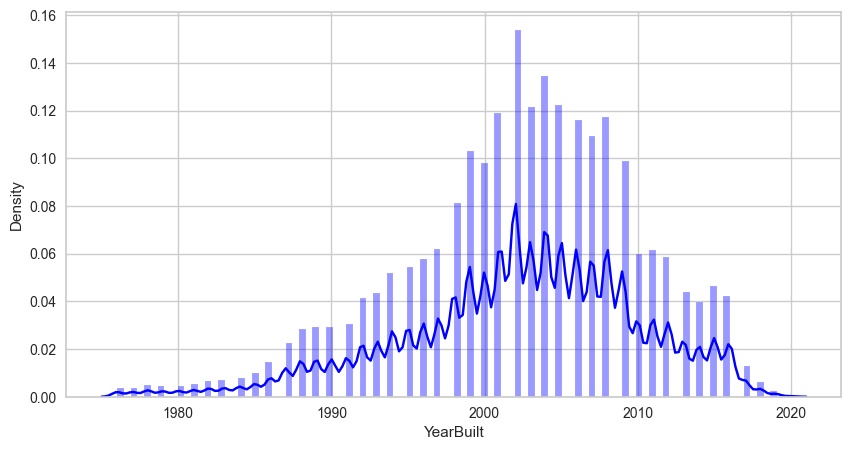

In [131]:
#Show the distribution of YearBuilt
plt.figure(figsize=(10,5))
sns.distplot(train_copy['YearBuilt'], color='blue', bins=100, hist_kws={'alpha': 0.4});
plt.show()

In [132]:
#eliminate values higher than 40 in MonthsLastRev column
train_copy = train_copy[train_copy['MonthsLastRev'] < 40]

<Figure size 1000x500 with 0 Axes>

<AxesSubplot: xlabel='MonthsLastRev', ylabel='Density'>

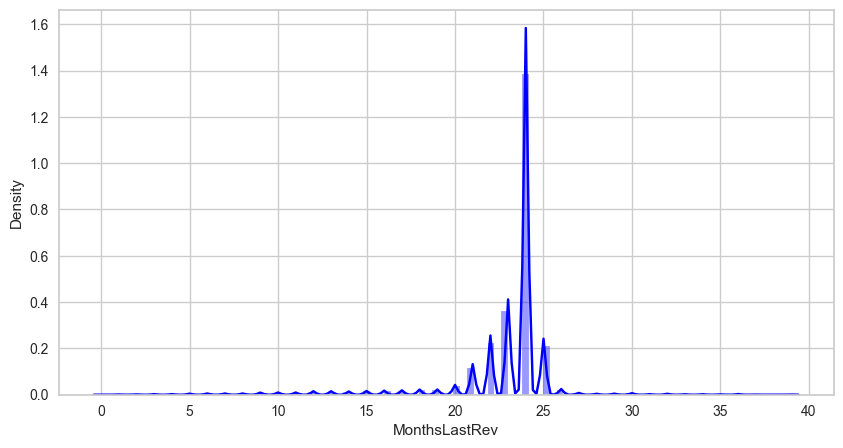

In [133]:
#show the distribution of MonthsLastRev
plt.figure(figsize=(10,5))
sns.distplot(train_copy['MonthsLastRev'], color='blue', bins=100, hist_kws={'alpha': 0.4});
plt.show()


In [134]:
# use describe function of monthslastrev column to see the distribution of values
train_copy['MonthsLastRev'].describe()


count   6057087.00
mean         22.97
std           3.09
min           0.00
25%          23.00
50%          24.00
75%          24.00
max          39.00
Name: MonthsLastRev, dtype: float64

In [135]:
#eliminate values higher than 400 in diameter column
train_copy = train_copy[train_copy['Diameter'] < 400]

<Figure size 1000x500 with 0 Axes>

<AxesSubplot: xlabel='Diameter', ylabel='Density'>

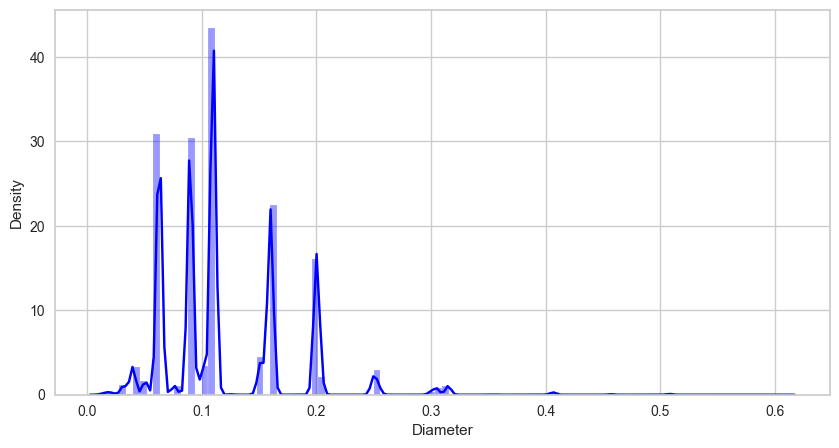

In [136]:
#show the distribution of Diameter
plt.figure(figsize=(10,5))
sns.distplot(train_copy['Diameter'], color='blue', bins=100, hist_kws={'alpha': 0.4});
plt.show()


In [137]:
cols = ['Age_pipe_at_inspection','Length','YearBuilt','InspectionYear'] # one or more

Q1 = train_copy[cols].quantile(0.25)
Q3 = train_copy[cols].quantile(0.75)
IQR = Q3 - Q1

train_copy = train_copy[~((train_copy[cols] < (Q1 - 1.5 * IQR)) |(train_copy[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [138]:
train_copy.shape

(5498133, 47)

<AxesSubplot: >

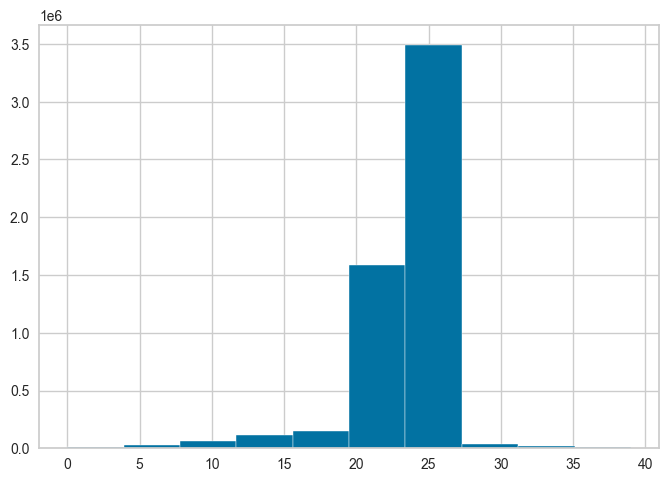

In [139]:
#graph histogram of MonthsLastRev column
train_copy['MonthsLastRev'].hist()

In [140]:
#plot column Length
train_copy['Length'].value_counts()

2.00      26387
1.00      25126
0.50      18245
1.50      17906
1.00      16884
          ...  
63.92         1
83.96         1
73.75         1
5.65          1
103.59        1
Name: Length, Length: 123872, dtype: int64

<AxesSubplot: >

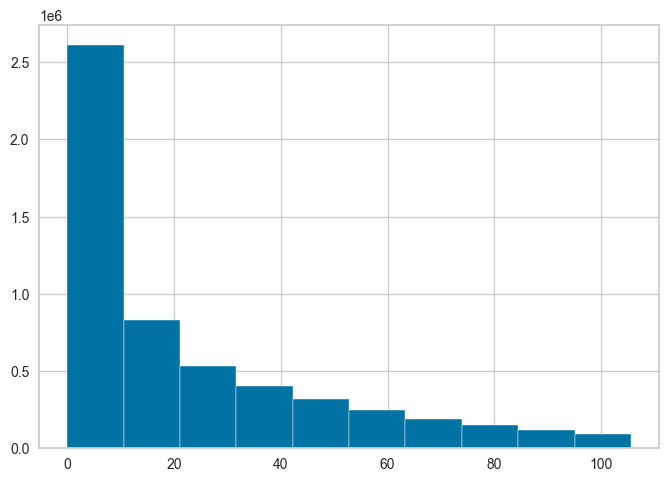

In [141]:
#plot histogram of Length column
train_copy['Length'].hist()

In [142]:
train_copy.columns

Index(['PipeId', 'No_Inspections', 'No_Incidents', 'InspectionYear',
       'Probability_rate', 'preventive_maintenance_rate',
       'Age_pipe_at_inspection', 'pipe_inspected_frequently',
       'Average_MonthsLastRev', 'MonthsLastRev', 'relative_risk',
       'average_severity_pipe', 'Incidence', 'YearBuilt', 'Diameter', 'Length',
       'Pressure', 'NumConnections', 'NumConnectionsUnder', 'BoolBridle',
       'aspect', 'Relative_Thickness', 'pipe_area', 'area_connection',
       'incidence_area', 'connection_bool', 'Severity_high', 'Severity_medium',
       'Severity_low', 'gas_natural',
       'Material_Acrylonitrile-Butadiene-Styrene', 'Material_Copper',
       'Material_Fiberglass-Reinforced Plastic', 'Material_Polyethylene',
       'Material_Polypropylene', 'Diameter2', 'Length2', 'Pressure2',
       'Average yearly temperature (°C)', 'Min. Temperature (°C)',
       'Max. Temperature (°C)', 'Yearly Rainfall (mm)',
       'Average year Humidity (%)', 'Rainy days per year (days)',

# Dropping section
Dropping will be done here

In [143]:
#delete the rows with YearBuilt higher than InspectionYear
train_copy = train_copy.drop(train_copy[(train_copy['YearBuilt'] > train_copy['InspectionYear'])].index)

In [144]:
#train_copy.drop('InspectionDate', axis=1, inplace=True)

In [145]:
#show null values in train_copy
train_copy.isnull().sum()
    

PipeId                                      0
No_Inspections                              0
No_Incidents                                0
InspectionYear                              0
Probability_rate                            0
preventive_maintenance_rate                 0
Age_pipe_at_inspection                      0
pipe_inspected_frequently                   0
Average_MonthsLastRev                       0
MonthsLastRev                               0
relative_risk                               0
average_severity_pipe                       0
Incidence                                   0
YearBuilt                                   0
Diameter                                    0
Length                                      0
Pressure                                    0
NumConnections                              0
NumConnectionsUnder                         0
BoolBridle                                  0
aspect                                      0
Relative_Thickness                

In [146]:
#delete nulls from train_copy
train_copy = train_copy.dropna()


# Exporting the new dataset for a next notebook

In [147]:
#point to the folder where the data is stored
os.chdir(r"C:\Users\pedro\datathon")
#export the dataframe to a csv file
train_copy.to_csv('train_consolidated_weather.csv', index=False)

# Plotting EDA for new dataset

In [148]:
#pandas profiling on the train_copy dataframe
profile = ProfileReport(train_copy, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_file("train_consolidated_weather.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# The Archive Section
Just in case we regret....
NOT DELETED JUST IN CASE NEEDED, HIGHLY CONFIDENT WE DONT NEED THESE


#aggregate the number of Age_pipe_inspection in a new column
train_copy['Aggregate_pipe_age_inspection'] = train_copy.groupby('PipeId')['Age_pipe_inspection'].transform('sum')
#place column in 10th position
cols = list(train_copy.columns.values)
cols.pop(cols.index('Aggregate_pipe_age_inspection'))
train_copy = train_copy[['PipeId', 'MaintenanceId', 'Inspections', 'Probability_incidence', 'Risk_S*I/Inspections', 'Average_MonthsLastRev',
    'Age_pipe_inspection', 'Aggregate_pipe_age_inspection', 'No_Incidents', 'Risk_S*I', 'average_severity', 'MonthsLastRev', 'Severity', 'Incidence', 'Province',
    'Town','YearBuilt', 'InspectionYear', 'InspectionDate','Material', 'GasType', 'Diameter', 'Length', 'Pressure',
    'NumConnections', 'NumConnectionsUnder', 'BoolBridle']]
train_copy.head(10)


#divide the Aggregate_pipe_age_inspection by the count of Incidence when is 1 and create new column with the average_age_pipe_inspection_when_incidence saving it in 10th position
train_copy['average_age_pipe_inspection_when_incidence'] = train_copy['Aggregate_pipe_age_inspection'] / train_copy.groupby('PipeId')['Incidence'].transform('count')
#place column in 10th position
cols = list(train_copy.columns.values)
cols.pop(cols.index('average_age_pipe_inspection_when_incidence'))
train_copy = train_copy[['PipeId', 'MaintenanceId', 'Inspections', 'Probability_incidence', 'Risk_S*I/Inspections', 'Average_MonthsLastRev',
    'Age_pipe_inspection', 'Aggregate_pipe_age_inspection', 'average_age_pipe_inspection_when_incidence', 'No_Incidents', 'Risk_S*I', 'average_severity', 'MonthsLastRev', 'Severity', 'Incidence', 'Province',
    'Town','YearBuilt', 'InspectionYear', 'InspectionDate','Material', 'GasType', 'Diameter', 'Length', 'Pressure',
    'NumConnections', 'NumConnectionsUnder', 'BoolBridle']]
#head of rows only where average_age_pipe_inspection_when_incidence when Incidence is 0
train_copy[train_copy['Incidence'] == 0].head(10)

#take PipeId column from df_submission dataframe and match it with PipeId column in train_copy dataframe to split train_copy into df_combined_train and df_combined_test. The test split should be the one with the higher number of rows
df_combined_test = train_copy[train_copy['PipeId'].isin(df_submission['PipeId'])]
df_combined_train = train_copy[~train_copy['PipeId'].isin(df_submission['PipeId'])]
#Do not look back at the test set until you are ready to submit your predictions


#take PipeId column from df_submission dataframe and match it with PipeId column in train_copy dataframe to split train_copy into df_combined_train and df_combined_test. The test split should be the one with the higher number of rows
df_combined_trained = train_copy[train_copy['PipeId'].isin(df_submission['PipeId'])]
df_combined_test = train_copy[~train_copy['PipeId'].isin(df_submission['PipeId'])]

#normalize df_combined_train_sub dataframe but the booleans
df_combined_train_sub_norm = df_combined_train_sub.copy()
df_combined_train_sub_norm[['Inspections', 'No_Incidents', 'Risk_S*I/Inspections', 'MonthsLastRev', 'Risk_S*I', 'Severity',
         'YearBuilt', 'Diameter', 'Length', 'Pressure', 'NumConnections','NumConnectionsUnder', 'TownCount']] = MinMaxScaler().fit_transform(df_combined_train_sub_norm[['Inspections', 'No_Incidents', 'Risk_S*I/Inspections', 'MonthsLastRev', 'Risk_S*I', 'Severity',
            'YearBuilt', 'Diameter', 'Length', 'Pressure', 'NumConnections','NumConnectionsUnder', 'TownCount']])
df_combined_train_sub_norm.head(2)

#Extract the day of the week from InspectionDate and place it in 5th position
train_copy['InspectionDay'] = train_copy['InspectionDate'].dt.day_name()
cols = list(train_copy.columns.values)
cols.pop(cols.index('InspectionDay'))
train_copy = train_copy[['PipeId', 'Inspections', 'No_Incidents', 'Risk_S*I/Inspections','leakage_estimate_factor','InspectionDay',
    'InspectionYear', 'InspectionDate', 'MonthsLastRev', 'Risk_S*I','Severity','Incidence', 'Province', 'Town', 'YearBuilt', 'Material', 'GasType',
    'Diameter', 'Length', 'Pressure', 'NumConnections', 'NumConnectionsUnder', 'BoolBridle']]
train_copy.head(1)


#on the train_copy if YEarBuilt is equal to 2021 and InspectionYear is equal to NaN, fill the InspectionYear with 2021
#train_copy.loc[(train_copy['YearBuilt'] > 2020) & (train_copy['InspectionYear'].isnull()), 'InspectionYear'] = 2021


#do a range in the train_copy for the YearBuilt column if the value is greater than 2020 and the InspectionYear is equal to Nan, change the value of InspectionYear to YearBuilt

for i in train_copy['YearBuilt']:
    if i > 2020:
        train_copy.loc[(train_copy['YearBuilt'] > 2020) & (train_copy['InspectionYear'].isnull()), 'InspectionYear'] = i